<a href="https://colab.research.google.com/github/thoufikumar/Alumni-Web-Design-UI/blob/main/AIML_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import glob
import os

# # Let's see what's inside the 'delhi_data' folder recursively
# print("--- File structure in 'delhi_data' ---")
# !ls -R delhi_data

# Use glob to find all CSV files inside 'delhi_data' and its subfolders
# The '**' part means it will look in all directories recursively
csv_files = glob.glob('/content/AshokVihar_Hourly.csv', recursive=True)

if not csv_files:
    print("\nError: No CSV files found in the 'delhi_data' directory.")
    print("Please check if the unzipping step worked correctly.")
else:
    # Load the first CSV file found
    station_file_path = csv_files[0]
    print(f"\nLoading file: {station_file_path}")

    df = pd.read_csv(station_file_path)

    # Display the first 5 rows
    print("\n--- First 5 Rows ---")
    print(df.head())

    # Display column names, data types, and non-null (missing) counts
    print("\n--- Data Info ---")
    df.info()


Loading file: /content/AshokVihar_Hourly.csv

--- First 5 Rows ---
   Unnamed: 0  PM2.5    year  month  day  hour   PM10     AT      BP    SR  \
0           0   77.0  2018.0    6.0  1.0   0.0  274.0  34.51  975.17  2.00   
1           1   75.0  2018.0    6.0  1.0   1.0  237.0  34.05  976.08  2.00   
2           2   81.0  2018.0    6.0  1.0   2.0  219.0  33.12  991.25  2.00   
3           3   70.0  2018.0    6.0  1.0   3.0  217.0  32.54  998.50  2.00   
4           4   74.0  2018.0    6.0  1.0   4.0  226.0  31.93  997.90  2.08   

   ...    WS     WD    NO    NO2    SO2  Ozone    CO  Benzene    NH3    NOx  
0  ...  7.42  129.0  3.21  23.36  10.93  98.13  0.53     5.14  43.00  26.55  
1  ...  7.43  129.0  2.93  21.71   9.48  97.80  0.51     3.94  47.82  24.64  
2  ...  7.43  129.0  2.27  11.90   1.68  46.27  0.12     4.55  10.64  15.24  
3  ...  7.42  129.0  1.72  10.70   2.97  35.88  0.30     4.20  13.44  42.32  
4  ...  7.41  129.0  1.83  32.49   2.73  26.55  0.39     3.32   8.48  44.

In [2]:
import pandas as pd
import glob

# --- 1. Load ALL CSV files ---
# Your screenshot shows they are in the main /content/ folder
file_pattern = '/content/*_Hourly.csv'
all_station_files = glob.glob(file_pattern)

print(f"Found {len(all_station_files)} station files:")
print(all_station_files)

# --- 2. Load and Combine ---
all_dfs = []
for file in all_station_files:
    # Read the CSV
    df_temp = pd.read_csv(file)

    # Extract station name from the filename
    # e.g., '/content/AshokVihar_Hourly.csv' -> 'AshokVihar'
    station_name = file.split('/')[-1].split('_Hourly.csv')[0]
    df_temp['station'] = station_name

    all_dfs.append(df_temp)

# Combine all individual dataframes into one
df = pd.concat(all_dfs, ignore_index=True)

print(f"\nSuccessfully combined all files. Total shape: {df.shape}")


# --- 3. Create Datetime Index ---
# Convert year, month, day, hour columns into a single datetime object
# We cast them to integers first, just in case
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']].astype(int))

# --- 4. Clean up Columns ---
# Drop the original date/time columns and the 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0', 'year', 'month', 'day', 'hour'])

# Set the new 'datetime' column as the index
df = df.set_index('datetime')

# Sort the index to make sure it's in chronological order
df = df.sort_index()


# --- 5. Final Inspection ---
print("\n--- Combined Data: First 5 Rows ---")
print(df.head())

print("\n--- Combined Data: Last 5 Rows ---")
print(df.tail())

print("\n--- Combined Data: Info ---")
df.info()

Found 1 station files:
['/content/AshokVihar_Hourly.csv']

Successfully combined all files. Total shape: (11705, 22)

--- Combined Data: First 5 Rows ---
                     PM2.5   PM10     AT      BP    SR     RH    WS     WD  \
datetime                                                                     
2018-06-01 00:00:00   77.0  274.0  34.51  975.17  2.00  62.17  7.42  129.0   
2018-06-01 01:00:00   75.0  237.0  34.05  976.08  2.00  62.33  7.43  129.0   
2018-06-01 02:00:00   81.0  219.0  33.12  991.25  2.00  65.00  7.43  129.0   
2018-06-01 03:00:00   70.0  217.0  32.54  998.50  2.00  66.92  7.42  129.0   
2018-06-01 04:00:00   74.0  226.0  31.93  997.90  2.08  69.83  7.41  129.0   

                       NO    NO2    SO2  Ozone    CO  Benzene    NH3    NOx  \
datetime                                                                      
2018-06-01 00:00:00  3.21  23.36  10.93  98.13  0.53     5.14  43.00  26.55   
2018-06-01 01:00:00  2.93  21.71   9.48  97.80  0.51     3.94 

In [3]:
import numpy as np

# Let's set our target variable
target = 'PM2.5'

# --- 1. Create Lagged and Rolling Features ---
# We must do this for each station separately, so we group by 'station'
# This prevents data from one station "leaking" into the lag of another.

print("Starting feature engineering (this may take a moment)...")

# Group by station and then apply the transformations
grouped = df.groupby('station')

# Create a new dataframe to hold the features
features_df = pd.DataFrame()

for station_name, group in grouped:
    # --- Lag Features ---
    # Shift the target variable back by 1, 2, 3, and 24 hours
    group[f'{target}_lag_1h'] = group[target].shift(1)
    group[f'{target}_lag_2h'] = group[target].shift(2)
    group[f'{target}_lag_3h'] = group[target].shift(3)
    group[f'{target}_lag_24h'] = group[target].shift(24)

    # --- Rolling Mean Feature ---
    # Calculate the 24-hour rolling average (excluding the current hour)
    group[f'{target}_roll_24h'] = group[target].shift(1).rolling(window=24).mean()

    # Append the processed group to our new dataframe
    features_df = pd.concat([features_df, group], axis=0)

print("Lagged and rolling features created.")


# --- 2. Create Cyclical Time Features ---
# Models understand "23 is close to 0" better with sin/cos
idx = features_df.index
features_df['hour'] = idx.hour
features_df['dayofweek'] = idx.dayofweek
features_df['month'] = idx.month

# Sine/Cosine transformations
features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)
features_df['month_sin'] = np.sin(2 * np.pi * features_df['month'] / 12)
features_df['month_cos'] = np.cos(2 * np.pi * features_df['month'] / 12)

# Drop the original time columns
features_df = features_df.drop(columns=['hour', 'dayofweek', 'month'])

print("Cyclical time features created.")


# --- 3. One-Hot Encode 'station' ---
# Convert the 'station' column into separate 0/1 columns
features_df = pd.get_dummies(features_df, columns=['station'], drop_first=True)
print("Station data one-hot encoded.")


# --- 4. Final Cleanup ---
# Our lag/roll features created NaN (empty) values at the start of each dataset
# We must drop these rows as we can't use them for training
features_df = features_df.dropna()

print("NaN rows dropped.")


# --- 5. Separate Features (X) and Target (y) ---
# 'y' is the column we want to predict (PM2.5)
y = features_df[target]

# 'X' is all the *other* columns we will use to make the prediction
X = features_df.drop(columns=[target])


# --- 6. Final Inspection ---
print(f"\nData preparation complete. We have {X.shape[0]} usable data points.")
print(f"Number of features: {X.shape[1]}")

print("\n--- First 5 Rows of X (Our Features) ---")
print(X.head())

print("\n--- First 5 Rows of y (Our Target) ---")
print(y.head())

Starting feature engineering (this may take a moment)...
Lagged and rolling features created.
Cyclical time features created.
Station data one-hot encoded.
NaN rows dropped.

Data preparation complete. We have 11681 usable data points.
Number of features: 24

--- First 5 Rows of X (Our Features) ---
                       PM10     AT      BP   SR     RH    WS     WD    NO  \
datetime                                                                    
2018-06-02 00:00:00  150.00  28.09  998.12  2.0  66.33  7.41  129.0  2.25   
2018-06-02 01:00:00  113.75  28.21  994.00  2.0  65.33  7.41  129.0  1.91   
2018-06-02 02:00:00  100.00  28.21  990.83  2.0  65.00  7.43  129.0  2.95   
2018-06-02 03:00:00   85.25  27.87  991.58  2.0  65.00  7.40  129.0  2.34   
2018-06-02 04:00:00   74.83  27.73  990.50  2.0  65.00  7.40  129.0  3.32   

                       NO2    SO2  ...    NOx  PM2.5_lag_1h  PM2.5_lag_2h  \
datetime                           ...                                      
2018-

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# --- 1. Split the Data (Chronologically) ---
# We MUST set shuffle=False for time-series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("--- Data Split ---")
print(f"Training data points: {len(X_train)}")
print(f"Testing data points:  {len(X_test)}")
print(f"Last training data timestamp: {X_train.index[-1]}")
print(f"First testing data timestamp: {X_test.index[0]}")


# --- 2. Build and Train the Model ---
print("\nTraining XGBoost model (this might take a few minutes)...")

# Instantiate the XGBoost Regressor
# n_estimators=1000: We'll build 1000 "trees"
# learning_rate=0.05: A small step size for better accuracy
# early_stopping_rounds=50: If the model's performance on the test set
#                           doesn't improve for 50 straight rounds, it will stop.
#                           This prevents overfitting and saves time.
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

# Train the model
# We use the test set as the evaluation set for early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100  # This will print the error every 100 trees
)

print("Model training complete.")


# --- 3. Evaluate the Model ---
print("\n--- Model Evaluation on Test Set ---")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f} μg/m³")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")

if r2 > 0.5:
    print(f"\nSuccess! Our R² score ({r2:.4f}) is greater than your 0.5 goal.")
else:
    print(f"\nOur R² score ({r2:.4f}) is not yet above 0.5. We may need to fine-tune.")

--- Data Split ---
Training data points: 9344
Testing data points:  2337
Last training data timestamp: 2019-06-26 07:00:00
First testing data timestamp: 2019-06-26 08:00:00

Training XGBoost model (this might take a few minutes)...
[0]	validation_0-rmse:81.08570
[100]	validation_0-rmse:8.05628
[200]	validation_0-rmse:7.92330
[300]	validation_0-rmse:7.77497
[400]	validation_0-rmse:7.73130
[438]	validation_0-rmse:7.73411
Model training complete.

--- Model Evaluation on Test Set ---
R-squared (R²) Score: 0.8953
Root Mean Square Error (RMSE): 7.7258 μg/m³
Mean Absolute Percentage Error (MAPE): 22.37%

Success! Our R² score (0.8953) is greater than your 0.5 goal.


--- Model Feature Importance ---


/tmp/ipython-input-534202216.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.head(15), palette='viridis')


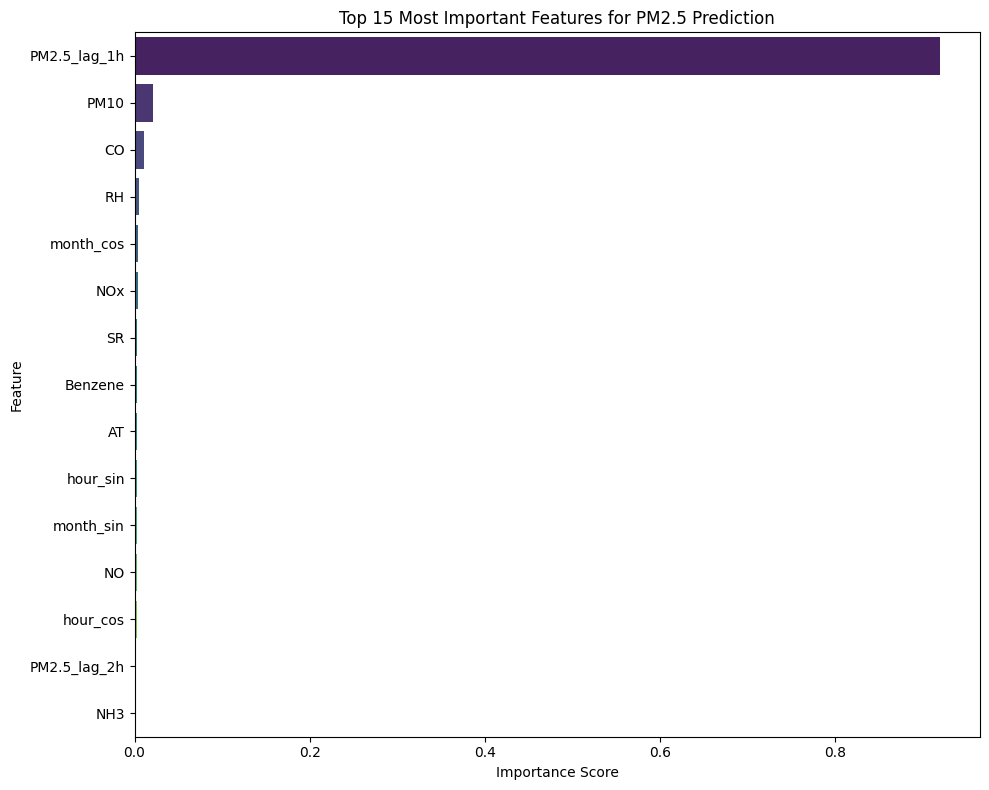


--- Visualizing Predictions ---


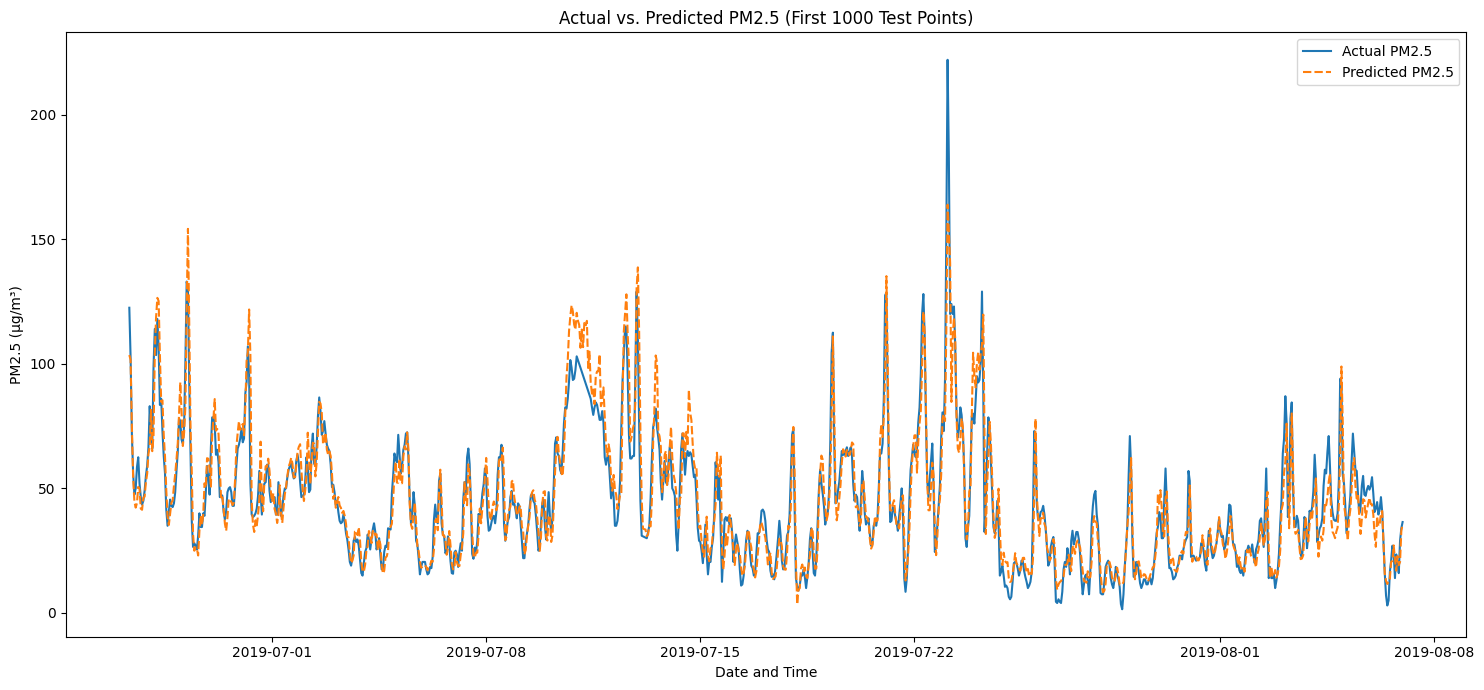

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Plot Feature Importance ---
print("--- Model Feature Importance ---")

# Create a simple dictionary of feature names and their importance scores
feature_importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot the top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Most Important Features for PM2.5 Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 2. Visualize Predictions (Actual vs. Predicted) ---
print("\n--- Visualizing Predictions ---")

# We don't want to plot all 14,000 test points, so let's
# plot a sample of the first 1,000 points.
plot_data = pd.DataFrame({
    'Actual PM2.5': y_test.iloc[:1000],
    'Predicted PM2.5': y_pred[:1000]
}).reset_index()

# Melt the dataframe for easy plotting with seaborn
plot_data_melted = plot_data.melt('datetime', var_name='Metric', value_name='PM2.5 Value')

# Create the line plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=plot_data_melted, x='datetime', y='PM2.5 Value', hue='Metric', style='Metric')
plt.title('Actual vs. Predicted PM2.5 (First 1000 Test Points)')
plt.ylabel('PM2.5 (μg/m³)')
plt.xlabel('Date and Time')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
print("Installing streamlit and pyngrok...")
!pip install -q streamlit pyngrok
print("Installation complete.")

Installing streamlit and pyngrok...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.7 MB/s eta 0:00:00
Installation complete.


In [7]:
print("Saving model and test data...")

# Save the XGBoost model
model.save_model("xgboost_model.json")

# Save the test data (X_test and y_test)
X_test.to_csv("X_test_data.csv")
y_test.to_csv("y_test_data.csv")

print("Model and data saved successfully.")

Saving model and test data...
Model and data saved successfully.


In [8]:
%%writefile app.py

import streamlit as st
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# --- THIS IS THE FIX ---
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# ----------------------

# --- 1. Page Configuration ---
st.set_page_config(
    page_title="Delhi Air Quality Dashboard",
    page_icon="💨",
    layout="wide"
)

# --- 2. Load Data and Model ---
@st.cache_data  # Cache the data to load only once
def load_data():
    X_test = pd.read_csv("X_test_data.csv", index_col='datetime', parse_dates=True)
    y_test = pd.read_csv("y_test_data.csv", index_col='datetime', parse_dates=True)
    return X_test, y_test

@st.cache_resource # Cache the model to load only once
def load_model():
    model = xgb.XGBRegressor()
    model.load_model("xgboost_model.json")
    return model

st.title("💨 Delhi Air Quality Prediction Dashboard")
st.markdown("This dashboard analyzes and predicts PM2.5 levels for 6 monitoring stations in Delhi.")

X_test, y_test = load_data()
model = load_model()

# --- 3. Make Predictions ---
y_pred = model.predict(X_test)


# --- 4. Main Dashboard ---

# --- Row 1: Key Metrics ---
st.header("Model Performance Metrics")
col1, col2, col3 = st.columns(3)

r2 = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # This line will work now
mape = mean_absolute_percentage_error(y_test, y_pred) # This line will work now

col1.metric("R-squared (R²)", f"{r2:.4f}")
col2.metric("Root Mean Square Error (RMSE)", f"{rmse:.2f} μg/m³")
col3.metric("Mean Absolute % Error (MAPE)", f"{mape*100:.2f}%")


# --- Row 2: Prediction Visualization ---
st.header("Actual vs. Predicted PM2.5 Forecast")
st.markdown("This chart shows the model's predictions against the actual PM2.5 values from the test set (20% of data).")

# Create a dataframe for plotting
plot_data = pd.DataFrame({
    'Actual PM2.5': y_test.iloc[:, 0], # Select first column from y_test
    'Predicted PM2.5': y_pred
})

# Display a line chart
st.line_chart(plot_data)


# --- Row 3: Analysis and Insights ---
st.header("Project Insights")
col_a, col_b = st.columns(2)

with col_a:
    # --- 4a. Feature Importance ---
    st.subheader("Key Drivers of Air Pollution")

    importance_df = pd.DataFrame({
        'feature': model.feature_names_in_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Plot the top 10 features
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(
        x='importance',
        y='feature',
        data=importance_df.head(10),
        palette='viridis',
        ax=ax
    )
    ax.set_title('Top 10 Most Important Features')
    ax.set_xlabel('Importance Score')
    ax.set_ylabel('Feature')

    # Use st.pyplot to display the Matplotlib figure
    st.pyplot(fig)

with col_b:
    # --- 4b. Pollutant Breakdown ---
    st.subheader("Average Pollutant & Weather Levels (Test Set)")

    # Select only the original pollutant/weather columns for averaging
    # We find columns that are NOT our engineered features
    original_cols = [
        'PM10', 'AT', 'BP', 'SR', 'RH', 'WS', 'WD',
        'NO', 'NO2', 'SO2', 'Ozone', 'CO', 'Benzene', 'NH3', 'NOx'
    ]

    # Calculate and display the mean
    avg_levels = X_test[original_cols].mean()
    st.dataframe(avg_levels.to_frame('Average Value'))

Writing app.py


In [9]:
from pyngrok import ngrok

# Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_TOKEN = input("34YO5aMuX522jsZN32raijBmtgC_22KfLq3SSsmhkUJCi9cY2")
ngrok.set_auth_token(NGROK_TOKEN)

# Run streamlit in the background
!nohup streamlit run app.py &

# Open a tunnel to the streamlit port (8501)
public_url = ngrok.connect(8501)
print("\nYour dashboard is live!")
print(f"Click here to open: {public_url}")

34YO5aMuX522jsZN32raijBmtgC_22KfLq3SSsmhkUJCi9cY234YO5aMuX522jsZN32raijBmtgC_22KfLq3SSsmhkUJCi9cY2
nohup: appending output to 'nohup.out'

Your dashboard is live!
Click here to open: NgrokTunnel: "https://lazy-subquarterly-mora.ngrok-free.dev" -> "http://localhost:8501"


In [10]:
from graphviz import Digraph

dot = Digraph(comment='Air Quality Prediction Pipeline')

dot.node('A', 'Data Collection\n(OpenAQ, EPA, Kaggle)')
dot.node('B', 'Data Preprocessing\n(Missing values, Outliers, Scaling)')
dot.node('C', 'Feature Engineering\n(Lag features, Rolling avg, Time encoding)')
dot.node('D', 'Train-Test Split\n(Chronological)')
dot.node('E', 'Model Training\n(XGBoost / LSTM)')
dot.node('F', 'Model Evaluation\n(RMSE, R2, MAPE)')
dot.node('G', 'Prediction\n(Forecast PM2.5)')
dot.node('H', 'Visualization & Dashboard\n(Streamlit)')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH'])

dot.render('air_quality_pipeline', view=True)


'air_quality_pipeline.pdf'